# Embedding Antibody Sequences using Sapiens

Try out this notebook in your browser: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Merck/Sapiens/main?labpath=notebooks%2F02_sapiens_antibody_embedding.ipynb)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
np.random.seed(42)
import re
np.random.seed(42)
tf.random.set_seed(42)
import pickle
import sys
import gc
import sapiens
from sklearn.manifold import TSNE

In [2]:
# from transformers import AdamWeightDecay, TFAutoModelForSequenceClassification, AutoTokenizer

# # model = sapiens.load_cached_model(model_dir, 'checkpoint_vh.pt')

# model = TFAutoModelForSequenceClassification.from_pretrained('v1', num_labels=2)

# model.compile(optimizer=AdamWeightDecay(2e-5), metrics=["accuracy"])
# model.summary()

## Get antibody embeddings

Get a vector representation of each position in a sequence

In [3]:
residue_embed = sapiens.predict_residue_embedding(
    "QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS", 
    "H", 
    layer=None # what does this do
)
residue_embed.shape
# (layer, position in sequence, features)

2023-01-02 12:33:22 | INFO | fairseq.file_utils | loading archive file /Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/sapiens/models/v1
2023-01-02 12:33:22 | INFO | fairseq.file_utils | loading archive file /Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/sapiens/models/v1
2023-01-02 12:33:24 | INFO | fairseq.tasks.masked_lm | dictionary: 24 types
2023-01-02 12:33:24 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'simple', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': 'data/models/human_heavy_chain_by_year/seq_random20M/13_unmasked_700epochs/tensorboard', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp

(5, 119, 128)

Get a single vector for each sequence

In [4]:
seq_embed = sapiens.predict_sequence_embedding(
    "QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS", 
    "H", 
    layer=None
)
seq_embed.shape
# (layer, features)

(5, 128)

In [5]:
# Sequence embedding from the last layer of our model
seq_embed[-1]

array([-9.07480791e-02,  9.95292738e-02,  4.42705542e-01,  1.76951751e-01,
        1.17761545e-01, -1.94502075e-03,  2.34257001e-02, -3.50218207e-01,
       -1.85383856e-01,  7.15081319e-02, -1.35001719e-01, -1.80759132e-01,
       -3.13717499e-03,  2.38733739e-02, -3.96349840e-02, -7.37676695e-02,
       -2.38686636e-01,  1.95218131e-01,  9.86457169e-02,  1.79552987e-01,
        3.17243300e-02, -3.33917588e-01, -8.63289684e-02, -5.02105765e-02,
       -7.52736256e-02,  1.59550109e-03, -4.97664243e-01, -1.65068477e-01,
       -4.22390401e-02,  2.61183560e-01, -2.77938396e-01, -1.29462048e-01,
       -1.64009873e-02,  4.70854566e-02,  5.25907613e-02,  8.33637826e-03,
       -4.97908801e-01,  7.72486776e-02,  7.08041430e-01, -3.29064220e-01,
        2.71839738e-01,  8.34675133e-02,  1.49200663e-01, -3.49690691e-02,
       -5.01605451e-01,  2.26801913e-02,  4.20484617e-02, -1.35063633e-01,
        5.07040648e-03, -2.95582205e-01,  1.43243209e-01, -1.41043007e-01,
       -3.53062041e-02, -

## Load Data

In [3]:
df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
5,QITLKESGPTLVKPTQTLTLTCKLSGFSVNTGGVGVGWIRQPPGKA...
32,QVQLVQSGAEVKKPGSSVKVSCKASGDTFNIYAINWVRQAPGQGLE...
33,QVQLVQSGAEVKKPGSSVKVSCKASGGTFNSYAITWVRQAPGQGLE...
34,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTHGMHWVRQAPGKGLE...
35,QVQLVQSGAEVKKPGSSVKVSCKASGGTFRRYAISWVRQAPGQGLE...
...,...
11862,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
11863,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
11864,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
11865,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [4]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 11415:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 11415


In [5]:
del head
del myfile
del dummy
gc.collect()

0

In [6]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

138
138


In [7]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

In [8]:
covid_sequence_embeddings = [sapiens.predict_sequence_embedding(i, chain_type="H", layer=-1) for i in covid_sequences]
print(np.shape(covid_sequence_embeddings))

2023-02-09 22:20:51 | INFO | fairseq.file_utils | loading archive file /Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/sapiens/models/v1
2023-02-09 22:20:51 | INFO | fairseq.file_utils | loading archive file /Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/sapiens/models/v1
2023-02-09 22:20:52 | INFO | fairseq.tasks.masked_lm | dictionary: 24 types
2023-02-09 22:20:52 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'simple', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': 'data/models/human_heavy_chain_by_year/seq_random20M/13_unmasked_700epochs/tensorboard', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp

(11415, 128)


In [9]:
healthy_sequence_embeddings = [sapiens.predict_sequence_embedding(i, chain_type="H", layer=-1) for i in healthy_sequences]
print(np.shape(covid_sequence_embeddings))

(11415, 128)


In [10]:
covid_residue_embeddings = [sapiens.predict_residue_embedding(i, chain_type="H", layer=-1) for i in covid_sequences]

In [11]:
healthy_residue_embeddings = [sapiens.predict_residue_embedding(i, chain_type="H", layer=-1) for i in healthy_sequences]

In [12]:
global_maxlen = 138 # this needs to be known a priori, from the max aa length block earlier

def pad_to_dense(M):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` looses its jagedness."""

    Z = np.zeros((len(M), global_maxlen, 128))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] = row 
    return Z

In [13]:
covid_residue_embeddings = pad_to_dense(covid_residue_embeddings)
healthy_residue_embeddings = pad_to_dense(healthy_residue_embeddings)

In [14]:
healthy_lables = [0] * 11415
covid_lables = [1] * 11415

## Visualization

In [15]:
embeds = np.concatenate((covid_sequence_embeddings, healthy_sequence_embeddings))

In [16]:
%%time

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=10)
X_embedded = tsne.fit_transform(embeds)

CPU times: user 3min, sys: 4.86 s, total: 3min 5s
Wall time: 47.6 s


In [17]:
all_sequences = np.concatenate((covid_sequences, healthy_sequences))
disease_labels = ['COVID-19'] * 11415 + ['Healthy'] * 11415

In [18]:
df = pd.DataFrame()
df.insert(0, 't-SNE 1', X_embedded[:,0])
df.insert(1, 't-SNE 2', X_embedded[:,1])
df.insert(2, 'Sequence', all_sequences)
df.insert(3, 'Disease Label', disease_labels)
df

,t-SNE 1,t-SNE 2,Sequence,Disease Label
0,-59.796597,59.144760,QVQLVQSGAEMKKPGASVKISCKASGDTFTTNYFHWVRQAPGQGLE...,COVID-19
1,-48.897633,-36.480183,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYGMHWVRQAPGKGLE...,COVID-19
2,-65.530830,81.363457,QVQLVQSGAEVKKPGASVKVSCQASGATFTIYGFHWVRQAPGQGLE...,COVID-19
3,-7.639406,33.785343,EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,COVID-19
4,-4.876585,-83.371346,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,COVID-19
...,...,...,...,...
22825,100.982635,-20.727703,TLSLTCAVSGYSINNAYFWGWIRQPPGGGLEWIGSLYHSGSTYYTP...,Healthy
22826,-60.596554,85.670357,EVQLVESGTEVKKPGASVKVSCKTSGYTFKSYGIIWVRQAPGQGLE...,Healthy
22827,53.974155,-51.784969,RQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLEW...,Healthy
22828,89.003693,27.369688,WSLRLSCAASGFTFSDYYMTWIRQAPGKGLEWVSYISGSNSFINYG...,Healthy


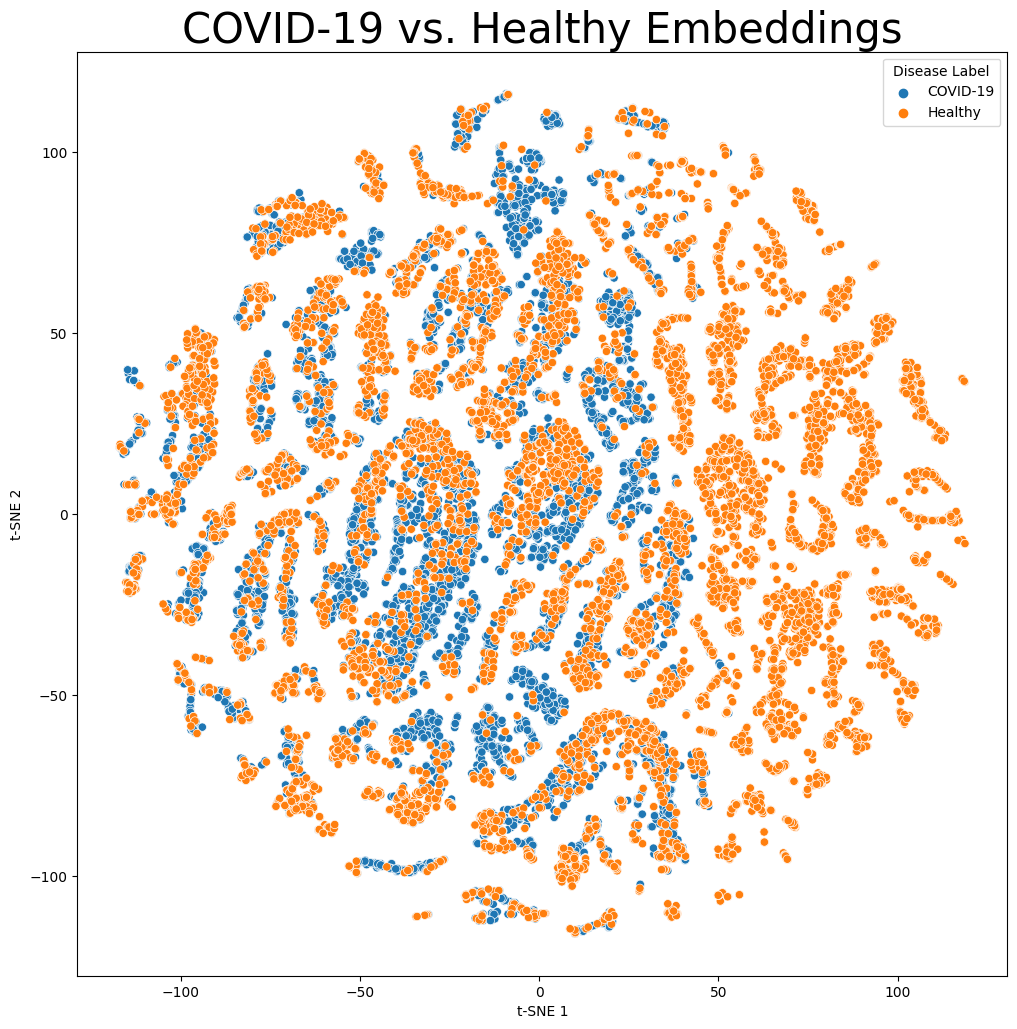

: 

In [23]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    hue="Disease Label",
    data=df,
    legend="full"
)
plt.title("COVID-19 vs. Healthy Embeddings", fontsize=30)
plt.show()

In [36]:
# An SVM would be really terrible at this

# Model 1

In [21]:
X = np.concatenate((healthy_residue_embeddings, covid_residue_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [22]:
del healthy_residue_embeddings
del covid_residue_embeddings
gc.collect()

0

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [24]:
del X
del y
gc.collect()

0

In [25]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [26]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(138, 1024)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.summary()

# Change stuff here

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (6, 6), activation='relu', input_shape=(138, 128, 1)),
  tf.keras.layers.MaxPooling2D((3,3), padding='same'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-02 12:48:29.898242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-02 12:48:29.899328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 123, 64)      2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 41, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 45, 41, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 37, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 19, 64)       0         
 2D)                                                             
                                                        

In [35]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/50


2023-01-01 10:49:56.011064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.7464

2023-01-01 10:50:30.396575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - 36s 60ms/step - loss: 0.4755 - accuracy: 0.7464 - val_loss: 0.4625 - val_accuracy: 0.7620
Epoch 2/50
578/578 [==============================] - 34s 58ms/step - loss: 0.4228 - accuracy: 0.7766 - val_loss: 0.3963 - val_accuracy: 0.8005
Epoch 3/50
578/578 [==============================] - 34s 59ms/step - loss: 0.3884 - accuracy: 0.8094 - val_loss: 0.3882 - val_accuracy: 0.8204
Epoch 4/50
578/578 [==============================] - 34s 60ms/step - loss: 0.3604 - accuracy: 0.8272 - val_loss: 0.3553 - val_accuracy: 0.8389
Epoch 5/50
578/578 [==============================] - 34s 60ms/step - loss: 0.3392 - accuracy: 0.8411 - val_loss: 0.3820 - val_accuracy: 0.8341
Epoch 6/50
578/578 [==============================] - 34s 59ms/step - loss: 0.3162 - accuracy: 0.8530 - val_loss: 0.3431 - val_accuracy: 0.8482
Epoch 7/50
578/578 [==============================] - 34s 58ms/step - loss: 0.3041 - accuracy: 0.8614 - val_loss: 0.3740 - val_accuracy: 0.8350
Epo

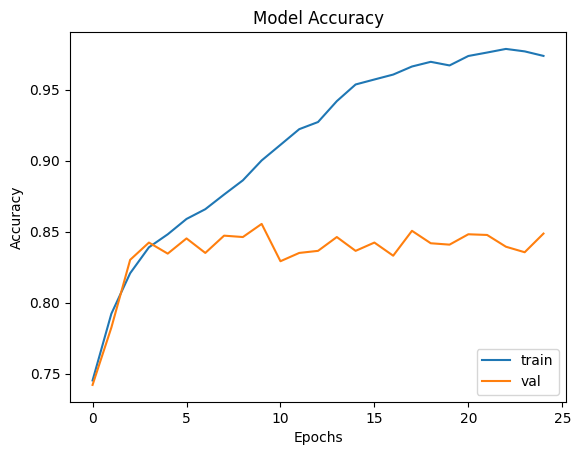

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 1 Testing

In [37]:
model.evaluate(X_test, y_test)

72/72 [==============================] - 1s 16ms/step - loss: 0.4967 - accuracy: 0.8445


[0.496677964925766, 0.844502866268158]

In [38]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

2023-01-01 14:02:08.832947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 17ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

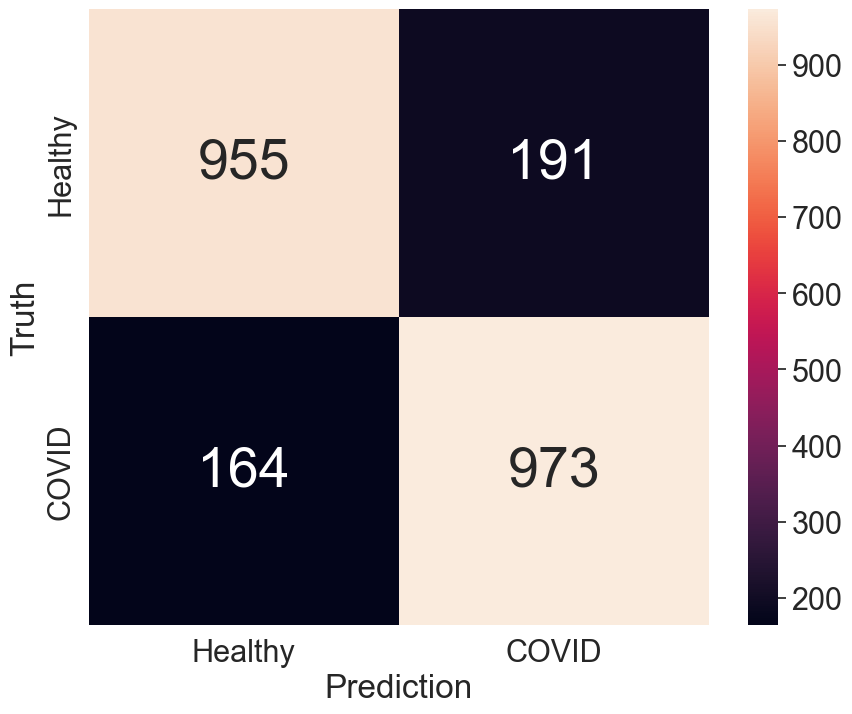

tf.Tensor(
[[955 191]
 [164 973]], shape=(2, 2), dtype=int32)


In [39]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [40]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

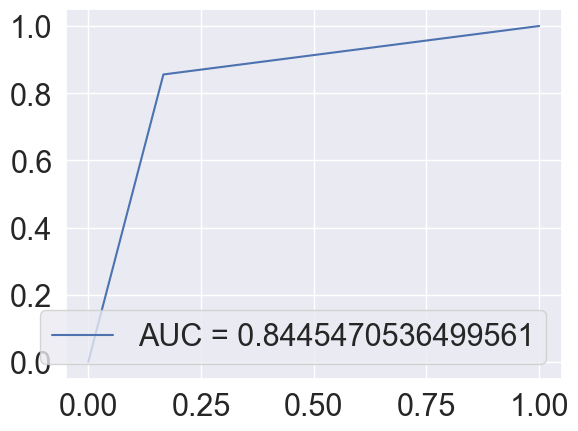

In [41]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

# Model 2: Sequence Embeddings

In [42]:
X = np.concatenate((healthy_sequence_embeddings, covid_sequence_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [43]:
del healthy_sequence_embeddings
del covid_sequence_embeddings
gc.collect()

123335

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [45]:
del X
del y
gc.collect()

0

In [46]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
X_val = np.asarray(X_val).astype('float32')

In [64]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(128,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 128)               16512     
                                                                 
 dense_75 (Dense)            (None, 64)                8256      
                                                                 
 dense_76 (Dense)            (None, 32)                2080      
                                                                 
 dense_77 (Dense)            (None, 16)                528       
                                                                 
 dense_78 (Dense)            (None, 1)                 17        
                                                                 
Total params: 27,393
Trainable params: 27,393
Non-tra

In [65]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [66]:
history = model.fit(X_train, y_train, epochs=100, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/100


2023-01-01 14:37:56.774848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.7594

2023-01-01 14:38:03.379108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - 7s 12ms/step - loss: 0.4557 - accuracy: 0.7594 - val_loss: 0.4257 - val_accuracy: 0.7805
Epoch 2/100
578/578 [==============================] - 6s 11ms/step - loss: 0.4195 - accuracy: 0.7824 - val_loss: 0.4100 - val_accuracy: 0.8019
Epoch 3/100
578/578 [==============================] - 6s 11ms/step - loss: 0.4039 - accuracy: 0.7990 - val_loss: 0.4092 - val_accuracy: 0.7981
Epoch 4/100
578/578 [==============================] - 6s 11ms/step - loss: 0.3918 - accuracy: 0.8039 - val_loss: 0.3883 - val_accuracy: 0.8141
Epoch 5/100
578/578 [==============================] - 6s 11ms/step - loss: 0.3823 - accuracy: 0.8127 - val_loss: 0.3886 - val_accuracy: 0.8092
Epoch 6/100
578/578 [==============================] - 6s 11ms/step - loss: 0.3776 - accuracy: 0.8118 - val_loss: 0.3848 - val_accuracy: 0.8107
Epoch 7/100
578/578 [==============================] - 6s 11ms/step - loss: 0.3728 - accuracy: 0.8149 - val_loss: 0.3783 - val_accuracy: 0.8273
Epoc

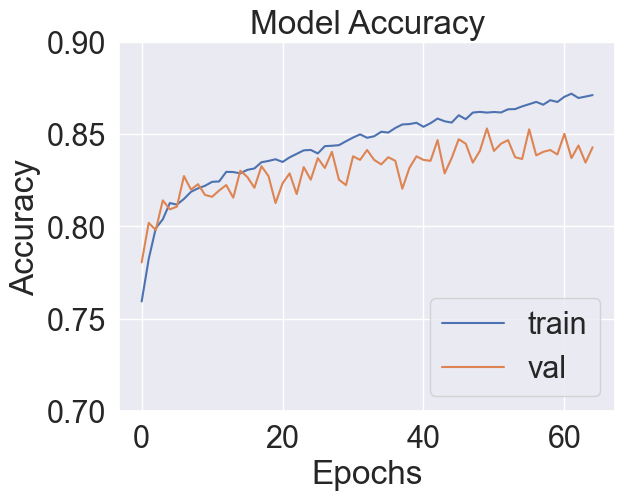

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim(0.7, 0.9)
plt.show()

## Model 2 Testing

In [68]:
model.evaluate(X_test, y_test)

72/72 [==============================] - 1s 8ms/step - loss: 0.3848 - accuracy: 0.8362


[0.3847983181476593, 0.8361805081367493]

In [69]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 18ms/step


2023-01-01 15:22:47.406752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

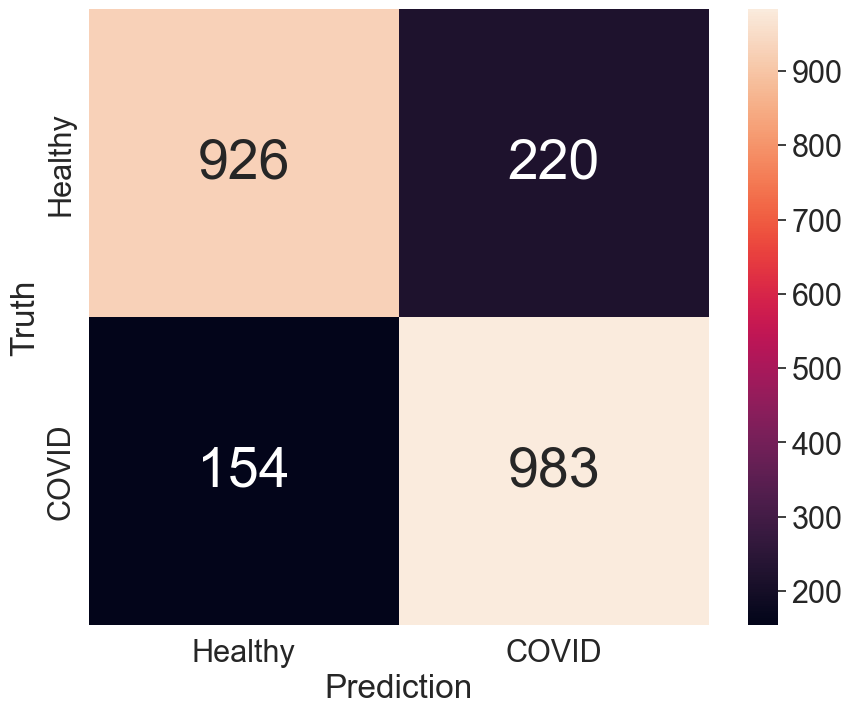

tf.Tensor(
[[926 220]
 [154 983]], shape=(2, 2), dtype=int32)


In [70]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [71]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

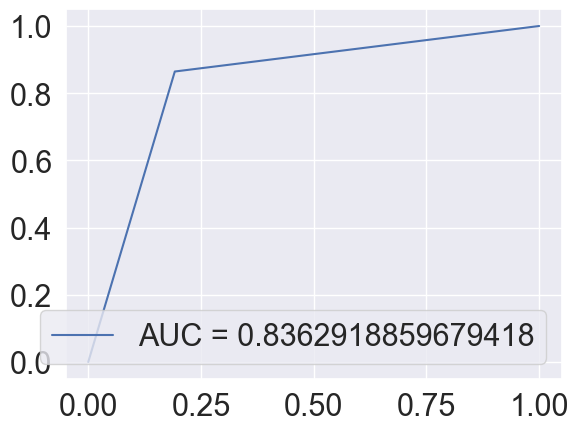

In [72]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()